# 3D Convolutions for track finding

In this notebook we try 3D convolution instead of LSTM for classifying pixels, etc.

In [1]:
# System imports
import math
from __future__ import print_function

# External imports
import numpy as np
import matplotlib.pyplot as plt
from keras import models
from keras import layers
import keras.backend as K

# Local imports
from metrics import calc_hit_accuracy

# Magic
%matplotlib notebook

Using Theano backend.
Using gpu device 0: GeForce GTX 980 Ti (CNMeM is enabled with initial size: 80.0% of memory, cuDNN 4007)


In [2]:
# Set random seed
np.random.seed(2017)

## Utilities

In [3]:
def draw_layer(ax, data, title=None, **kwargs):
    """Draw one detector layer as an image"""
    ax.imshow(data.T, interpolation='none', aspect='auto',
              origin='lower', **kwargs)
    if title is not None:
        ax.set_title(title)

def draw_layers(event, ncols=5, truthx=None, truthy=None, figsize=(12,5)):
    """Draw each detector layer as a grid of images"""
    num_det_layers = event.shape[0]
    nrows = math.ceil(float(num_det_layers)/ncols)
    plt.figure(figsize=figsize)
    for ilay in range(num_det_layers):
        ax = plt.subplot(nrows, ncols, ilay+1)
        title = 'layer %i' % ilay
        draw_layer(ax, event[ilay], title=title)
        ax.autoscale(False)
        if truthx is not None and truthy is not None:
            ax.plot(truthx[ilay]-0.5, truthy[ilay]-0.5, 'w+')
    plt.tight_layout()

def draw_train_history(history, figsize=(12,5)):
    """Make plots of training and validation losses and accuracies"""
    plt.figure(figsize=figsize)
    # Plot loss
    plt.subplot(121)
    plt.plot(history.epoch, history.history['loss'], label='Training set')
    plt.plot(history.epoch, history.history['val_loss'], label='Validation set')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training loss')
    plt.legend()
    plt.subplot(122)
    plt.plot(history.epoch, history.history['acc'], label='Training set')
    plt.plot(history.epoch, history.history['val_acc'], label='Validation set')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim((0, 1))
    plt.title('Training accuracy')
    plt.legend()
    plt.tight_layout()

def draw_projections(event, truthx=None, truthy=None, figsize=(12,5)):
    plt.figure(figsize=figsize)
    plt.subplot(121)
    kwargs = dict(interpolation='none',
                  aspect='auto',
                  origin='lower')
    plt.imshow(event.sum(axis=1).T, **kwargs)
    plt.xlabel('detector layer')
    plt.ylabel('pixel')
    plt.autoscale(False)
    if truthy is not None:
        plt.plot(np.arange(event.shape[0]-0.5), truthy-0.5, 'w-')
    plt.subplot(122)
    plt.imshow(event.sum(axis=2).T, **kwargs)
    plt.xlabel('detector layer')
    plt.ylabel('pixel')
    plt.tight_layout()
    plt.autoscale(False)
    if truthx is not None:
        plt.plot(np.arange(event.shape[0]-0.5), truthx-0.5, 'w-')

In [4]:
def gen_noise(shape, prob=0.1, seed_layers=0):
    noise = (np.random.random_sample(shape) < prob).astype(np.int8)
    noise[:,:seed_layers,:,:] = 0
    return noise

def sample_track_params(n, num_det_layers, det_layer_size):
    # Sample the entry and exit points for tracks
    entry_points = np.random.uniform(0, det_layer_size, size=(n, 2))
    exit_points = np.random.uniform(0, det_layer_size, size=(n, 2))    
    # Calculate slope parameters
    slopes = (exit_points - entry_points) / float(num_det_layers - 1)
    return np.concatenate([slopes, entry_points], axis=1)

def track_hit_coords(params, det_layer_idx, as_type=np.int):
    xslope, yslope, xentry, yentry = params
    xhits = xslope*det_layer_idx + xentry
    yhits = yslope*det_layer_idx + yentry
    return xhits.astype(as_type), yhits.astype(as_type)
    
def gen_straight_tracks(n, num_det_layers, det_layer_size):
    # Initialize the data
    data = np.zeros((n, num_det_layers, det_layer_size, det_layer_size),
                    dtype=np.float32)
    # Sample track parameters
    params = sample_track_params(n, num_det_layers, det_layer_size)
    # Calculate hit positions and fill hit data
    idx = np.arange(num_det_layers)
    for ievt in range(n):
        xhits, yhits = track_hit_coords(params[ievt], idx)
        data[ievt,idx,xhits,yhits] = 1   
    return data, params

def gen_bkg_tracks(num_event, num_det_layers, det_layer_size,
                   avg_bkg_tracks=3, seed_layers=0):
    num_bkg_tracks = np.random.poisson(avg_bkg_tracks, num_event)
    bkg_tracks = np.zeros((num_event, num_det_layers, det_layer_size, det_layer_size),
                          dtype=np.float32)
    for ievt in range(num_event):
        ntrk = num_bkg_tracks[ievt]
        bkg_tracks[ievt] = sum(gen_straight_tracks(ntrk, num_det_layers, det_layer_size)[0])
    bkg_tracks[:,:seed_layers,:,:] = 0
    return bkg_tracks

## Data generation

In [5]:
# Configuration
num_event = 102400
num_det_layers = 10
det_layer_size = 32
num_seed_layers = 3
#avg_bkg_tracks = 3
#noise_prob = 0.01
shape = (num_event, num_det_layers, det_layer_size, det_layer_size)
det_shape = shape[1:]

In [6]:
def generate_data(shape, num_seed_layers=3, avg_bkg_tracks=3,
                  noise_prob=0.01, verbose=True):
    """
    Top level function to generate a dataset.
    TODO: finish documentation.
    """
    num_event, num_det_layers, det_layer_size, _ = shape
    # Signal tracks
    sig_tracks, sig_params = gen_straight_tracks(
        num_event, num_det_layers, det_layer_size)
    # Background tracks
    bkg_tracks = gen_bkg_tracks(
        num_event, num_det_layers, det_layer_size,
        avg_bkg_tracks=avg_bkg_tracks, seed_layers=num_seed_layers)
    # Noise
    noise = gen_noise(shape, prob=noise_prob, seed_layers=num_seed_layers)
    # Full events
    events = sig_tracks + bkg_tracks + noise
    events[events > 1] = 1
    # Print data sizes
    if verbose:
        print('Sizes of arrays')
        print('  events:     %g MB' % (events.dtype.itemsize * events.size / 1e6))
        print('  sig_tracks: %g MB' % (sig_tracks.dtype.itemsize * sig_tracks.size / 1e6))
        print('  bkg_tracks: %g MB' % (bkg_tracks.dtype.itemsize * bkg_tracks.size / 1e6))
        print('  noise:      %g MB' % (noise.dtype.itemsize * noise.size / 1e6))
    
    return events, sig_tracks, sig_params

In [7]:
# Generate all data
events, sig_tracks, sig_params = generate_data(shape, num_seed_layers=num_seed_layers)

Sizes of arrays
  events:     4194.3 MB
  sig_tracks: 4194.3 MB
  bkg_tracks: 4194.3 MB
  noise:      1048.58 MB


In [8]:
# Visualize one event
draw_layers(events[0])

<IPython.core.display.Javascript object>

## Define the model

In [9]:
def build_conv_model(shape, dropout=0.2):
    """Build the CNN model"""
    inputs = layers.Input(shape=shape, name='input')
    # Need a 'channel' dimension for 3D convolution, though we have only 1 channel
    hidden = layers.Reshape((1,)+shape, name='reshape_channel')(inputs)
    # 3D convolutional layers
    hidden = layers.Convolution3D(16, 3, 5, 5, border_mode='same',
                                  activation='relu', name='conv3d_1')(hidden)
    hidden = layers.Dropout(dropout)(hidden)
    hidden = layers.Convolution3D(16, 3, 5, 5, border_mode='same',
                                  activation='relu', name='conv3d_2')(hidden)
    #hidden = layers.MaxPooling3D(pool_size=(1, 2, 2))(hidden)
    hidden = layers.Dropout(dropout)(hidden)
    hidden = layers.Convolution3D(16, 3, 5, 5, border_mode='same',
                                  activation='relu', name='conv3d_3')(hidden)
    hidden = layers.Dropout(dropout)(hidden)
    hidden = layers.Convolution3D(8, 3, 5, 5, border_mode='same',
                                  activation='relu', name='conv3d_4')(hidden)
    hidden = layers.Dropout(dropout)(hidden)
    hidden = layers.Convolution3D(8, 3, 5, 5, border_mode='same',
                                  activation='relu', name='conv3d_5')(hidden)
    last_conv = layers.Convolution3D(1, 1, 1, 1, border_mode='same',
                                     activation='relu', name='conv3d_6')
    hidden = last_conv(hidden)

    # Reshape to flatten each detector layer
    hidden_shape = last_conv.output_shape
    hidden = layers.Reshape((hidden_shape[2], np.prod(hidden_shape[3:])),
                            name='reshape_flat')(hidden)
    # Output softmax
    outputs = layers.TimeDistributed(
        layers.Dense(shape[1]*shape[2], activation='softmax'),
        name='output_softmax')(hidden)
    
    # Compile the model
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss='categorical_crossentropy',
                  optimizer='Nadam', metrics=['accuracy'])
    return model

## Training

In [10]:
batch_size = 256
num_epoch = 10
valid_frac = 0.2

train_input = events
train_target = sig_tracks.reshape(num_event, num_det_layers, -1)

In [ ]:
m = build_conv_model(det_shape)
m.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input (InputLayer)               (None, 10, 32, 32)    0                                            
____________________________________________________________________________________________________
reshape_channel (Reshape)        (None, 1, 10, 32, 32) 0           input[0][0]                      
____________________________________________________________________________________________________
conv3d_1 (Convolution3D)         (None, 16, 10, 32, 32)1216        reshape_channel[0][0]            
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 16, 10, 32, 32)0           conv3d_1[0][0]                   
___________________________________________________________________________________________

In [ ]:
history = m.fit(train_input, train_target, batch_size=batch_size,
                nb_epoch=num_epoch, validation_split=valid_frac)

Train on 81920 samples, validate on 20480 samples
Epoch 1/10
30976/81920 [==========>...................] - ETA: 404s - loss: 5.4931 - acc: 0.0872

<IPython.core.display.Javascript object>


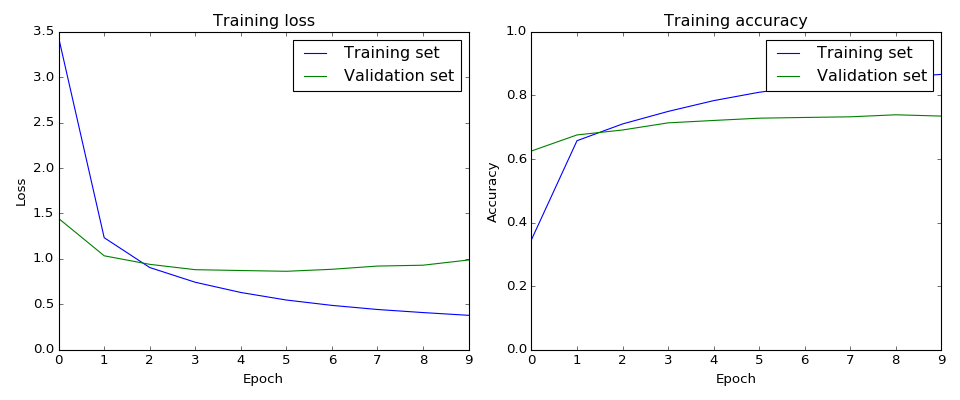

In [23]:
draw_train_history(history)

## Evaluate results

### Training + validation set

In [ ]:
# Get the predictions
train_preds = m.predict(train_input, batch_size=batch_size)

In [ ]:
# Hit prediction accuracy
pixel_accuracy = calc_hit_accuracy(train_preds, train_target,
                                   num_seed_layers=num_seed_layers)
# Hit classification accuracy
scores = train_preds * events.reshape(num_event, num_det_layers, -1)
hit_accuracy = calc_hit_accuracy(scores, train_target)
print('Accuracy of predicted pixel:', pixel_accuracy)
print('Accuracy of classified hit: ', hit_accuracy)

In [ ]:
# Cleanup
del sig_tracks, events, scores, train_input, train_target, train_preds

### Test set

In [ ]:
# Generate a new test dataset
test_num_event = 25600
test_events, test_sigtrks, test_sigparams = generate_data((test_num_event,) + det_shape)
test_target = test_sigtrks.reshape(test_num_event, num_det_layers, -1)

In [ ]:
print(m.evaluate(test_events, test_target, batch_size=batch_size))
test_preds = m.predict(test_events, batch_size=batch_size)

25600/25600 [==============================] - 50s    
[0.98587886214256282, 0.73546484410762791]


In [29]:
# Hit prediction accuracy
pixel_accuracy = calc_hit_accuracy(test_preds, test_target,
                                   num_seed_layers=num_seed_layers)
# Hit classification accuracy
test_scores = test_preds * test_events.reshape(test_num_event, num_det_layers, -1)
hit_accuracy = calc_hit_accuracy(test_scores, test_target)
print('Accuracy of predicted pixel:', pixel_accuracy)
print('Accuracy of classified hit: ', hit_accuracy)

Accuracy of predicted pixel: 0.6220926339285714
Accuracy of classified hit:  0.7361640625


In [30]:
# Select an event to visualize
disp_idx = 1

# Get the hit coordinates for drawing
idx = np.arange(num_det_layers)
xtruth, ytruth = track_hit_coords(test_sigparams[disp_idx], idx, as_type=np.float32)

<IPython.core.display.Javascript object>


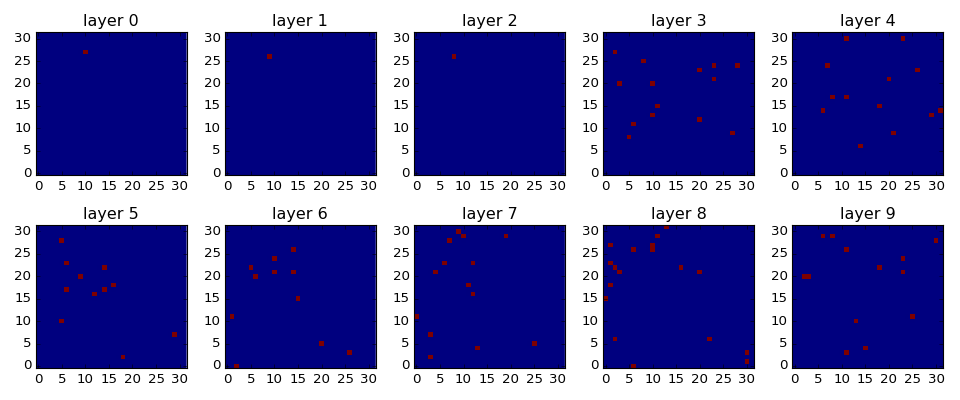

<IPython.core.display.Javascript object>


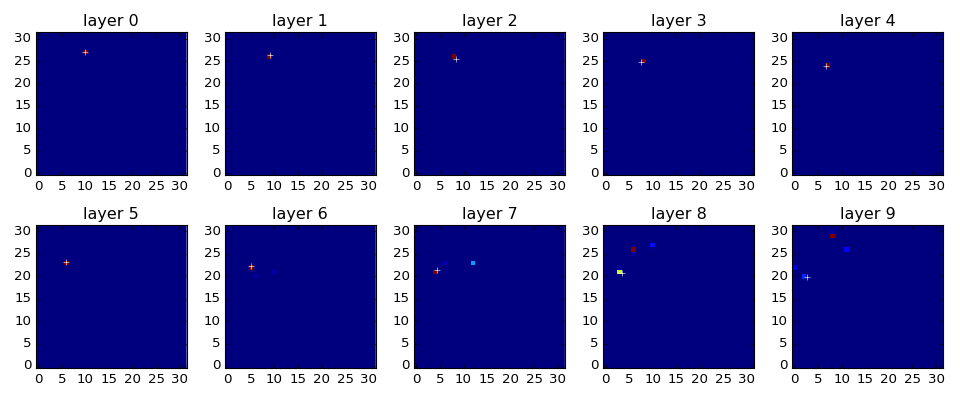

In [31]:
# Visualize one event
draw_layers(test_events[disp_idx])
draw_layers(test_preds[disp_idx].reshape(det_shape), truthx=xtruth, truthy=ytruth)

<IPython.core.display.Javascript object>


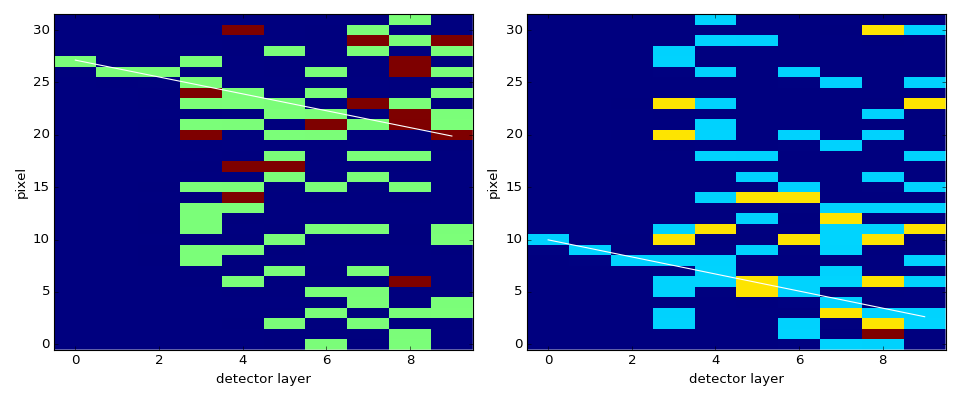

<IPython.core.display.Javascript object>


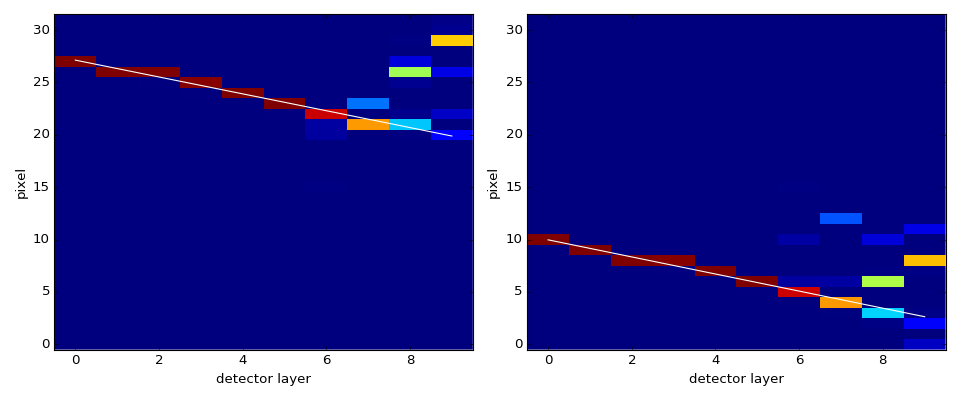

In [32]:
# Draw the 2D projections
draw_projections(test_events[disp_idx], truthx=xtruth, truthy=ytruth)
draw_projections(test_preds[disp_idx].reshape(det_shape), truthx=xtruth, truthy=ytruth)